# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.576137,True,5.311164
1,0.134082,True,7.034830
2,0.619580,True,4.721515
3,-1.006582,True,5.320655
4,0.501089,False,1.414797
...,...,...,...
995,0.286471,False,0.694648
996,-0.427592,False,-0.495062
997,-0.092285,False,-0.954352
998,1.249877,True,5.298827


<AxesSubplot: xlabel='v0'>

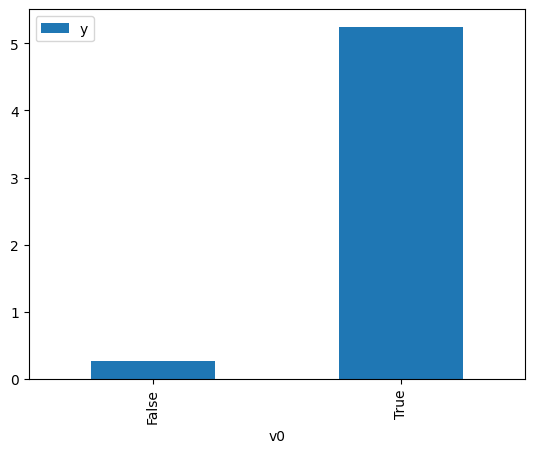

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

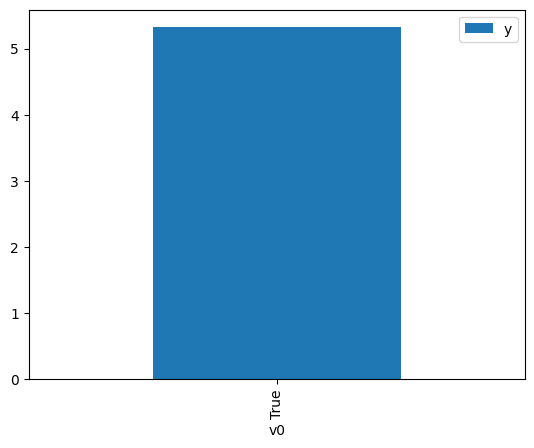

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.464482,False,1.962616,0.492070,2.032230
1,1.181961,False,0.462154,0.496512,2.014051
2,1.431247,False,0.503697,0.492593,2.030074
3,1.960463,False,1.572044,0.484277,2.064935
4,0.189002,False,-0.563123,0.512122,1.952661
...,...,...,...,...,...
995,0.164003,False,0.018390,0.512514,1.951165
996,-0.225210,False,0.489504,0.518628,1.928165
997,0.359810,False,-1.978185,0.509437,1.962950
998,1.255530,False,0.666235,0.495355,2.018754


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.636451,True,4.517692,0.494911,2.020564
1,0.657207,True,3.006623,0.495238,2.019232
2,-0.416703,True,4.746565,0.478366,2.090449
3,-0.670387,True,4.916105,0.474386,2.107986
4,1.584663,True,6.256285,0.509819,1.961482
...,...,...,...,...,...
995,1.353802,True,5.857645,0.506190,1.975544
996,0.657243,True,6.731408,0.495238,2.019230
997,1.032322,True,5.412787,0.501135,1.995468
998,0.835110,True,5.877864,0.498035,2.007892


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7762.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        14:52:02   Log-Likelihood:                         -1376.0
No. Observations:                1000   AIC:                                      2756.
Df Residuals:                     998   BIC:                                      2766.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5511      0.029     18.709      0.000       0.493       0.609
x2             5.0600      0.046    111.202      0.000       4.971       5.149
==============================================================================
Omnibus:                       16.215   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.564
Skew:                          -0.301   Prob(JB):                     0.000253
Kurtosis:                       3.187   Cond. No.                         1.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""